# Naive Bayes Classifier - Text Classification - Multinomial & Bernoulli

In this notebook we will learn how to apply the Naive Bayes algorithms for text classification. We will use a corpora of emails and classify them in one of the two classes: spam and non-spam (ham)

Naive Bayes methods are a set of supervised learning algorithms that use Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.


We investigate three different naive Bayes classifiers. These classifiers differ mainly by the assumptions they make regarding the distribution of the likelihhod of the features $p(x_j \mid y = c)$.

- Categorical features (binary valued) are modeled using the Multivariate Bernoulli distribution 
- Categorical features (multi-valued) are modeled using the Multinomial distribution 
- Real-valued features are modeled using the Gaussian distribution 

In this notebook we use the <strong> Multinomial and Multivariate Bernoulli NB </strong> classifiers.

In spite of their apparently over-simplified assumptions, Naive Bayes classifiers work quite well in many real-world situations, famously document classification and spam filtering. 

- Two key benefits of Naive Bayes models are.


## Benefit 1: Data Size Requirement
Naive Bayes classifiers **require a small amount of training data** to estimate the necessary parameters. 


## Benefit 2: Naturally Immune to the Curse of Dimensionality
Naive Bayes learners and classifiers can be **extremely fast** compared to more sophisticated methods. The time-efficiency is due to the decoupling of the class conditional feature distributions. It ensures that each distribution can be independently estimated as a one dimensional distribution. This in turn helps to alleviate problems stemming from the **curse of dimensionality**.



### Dataset

URL: https://www.kaggle.com/karthickveerakumar/spam-filter

The dataset consists of labeled emails belonging to both ham (label = 0) and spam (label = 1).


## Steps for Classification:

1. Exploratory Data Analysis
2. Feature Extraction
   - a. Text Normalization (Stemming & Lemmatization)
   - b. Text Preprocessing (Tokenization, removing stop words, etc.)
   - c. Vectorization of the features
3. Model Selection by Hyperparameter Tuning
4. Train the Optimal Model
5. Evaluate the Model on Test Data

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

[nltk_data] Downloading package wordnet to /Users/hasan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

Load data from the CSV file as a pandas DataFrame object.

In [2]:
df = pd.read_csv('/Users/hasan/datasets/emails.csv')

# <font color=blue> 1. Exploratory Data Analysis</font>

## Quick Check of the Data

Let’s take a look at the top five rows using the DataFrame’s head() method.

In [3]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


## Get Information on the Pandas Data Frame Object

Use pandas info method to print information about a DataFrame including the index dtype and columns, non-null values and memory usage.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
text    5728 non-null object
spam    5728 non-null int64
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


## Check if there are any null values in any column

In [5]:
df.isna().values.any()

False

## Observation: NaN Values

We observe that there are no missing values (i.e., NaN values) in the data frame object.

If there exists any NaN values in the "text" column, we should remove the rows containing NaN values using the following method.

df = df[df['text'].notna()]

## Dimension of the Data

In [6]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (5728, 2)

No. of Rows: 5728
No. of Columns: 2


## Class Distribution

In [7]:
df.groupby('spam').count()

,text
spam,
0,4360
1,1368


## Visualization of the Class Distribution

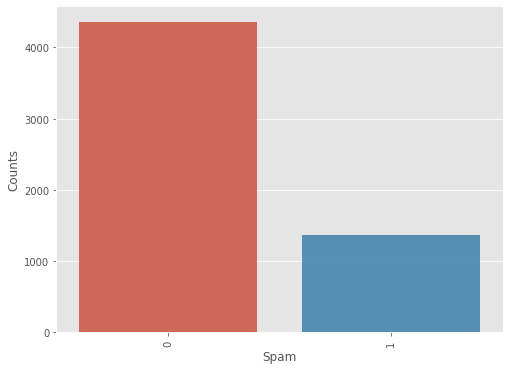

In [8]:
label_counts = df.spam.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha=0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

## Correlation Between the Email length & the Class (Ham/Spam)

We need to check whether the length of the emails are correlated to their classes (ham/spam).

In [9]:
# Create a new column "length" the stores the length of the text on each row
df['length'] = df['text'].map(lambda text: len(text))

df.groupby('spam').length.describe()

,count,mean,std,min,25%,50%,75%,max
spam,,,,,,,,
0,4360.0,1631.918119,1959.664549,13.0,577.75,1122.0,2037.25,43952.0
1,1368.0,1317.257310,2271.372893,18.0,401.50,693.5,1250.25,28432.0


## Visualize Length Distribution by Class

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10913a898>,
      dtype=object)

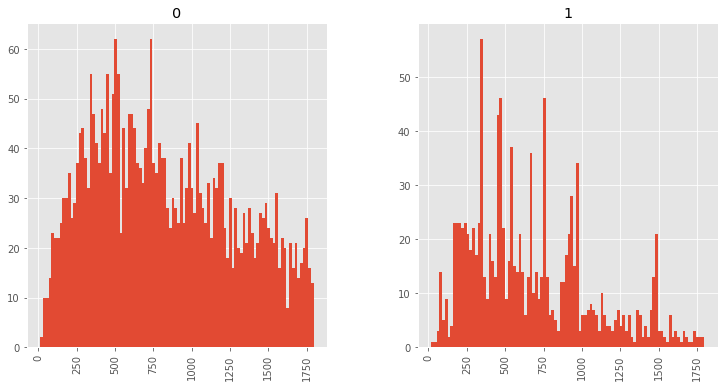

In [10]:
# Use a length threshold to visualize the distribution of length per class

threshold = 1800
emails_subset = df[df.length < threshold]
emails_subset.hist(column='length', by='spam', bins=100, figsize=(12, 6))

## Observation from the EDA

We observe that <strong><font color=red size=4>only 23.88%</font></strong> emails are spam.

Also there are some outliers (long emails).

# <font color=blue> 2. Feature Extraction </font>

## a) Text Normalization by Lemmatization

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of **Natural Language Processing** that are used to prepare text, words, and documents for further processing.

Lemmatization is more suitable for text classification. It's the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma, or **dictionary form**. So words like 'moved' & 'moving' will be reduced to 'move'.

However, please note that it is useful to try stemming as well. 

A good strategy is to try both stemming and lemmatization (separately and in combination), and to see which strategy improves the accuracy of classification.


While doing lemmatization, it is useful to remember three things:
- Lemmatization works only on individual words. Thus, we need to tokenize a document first.
- Unlike stemming, lemmatization does not work on capitalized words. Thus, we need to convert a word into lowercase before performning lemmatization.
- Unless a "lemmatized" word exists in the WordCloud dictionary (we imported it at the beginning of the notebook) we will not get a lemmatized version of a word from the text.


In [11]:
%%time
lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

CPU times: user 25.2 s, sys: 316 ms, total: 25.5 s
Wall time: 25.8 s


## Observe a Random Document Before and After Normalization

In [12]:
print("\nEmail (no lemmatization):\n")
print(df['text'][171])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][171])


Email (no lemmatization):

Subject: failure notice  hi . this is the qmail - send program at nsl . mxlinux 2 . com .  i ' m afraid i wasn ' t able to deliver your message to the following addresses .  this is a permanent error ; i ' ve given up . sorry it didn ' t work out .  :  this address no longer accepts mail .  - - - below this line is a copy of the message .  return - path :  received : ( qmail 30891 invoked from network ) ; 19 jul 2005 10 : 57 : 17 - 0000  received : from ntokymo 09176 . okym . nt . adsl . ppp . infoweb . ne . jp ( helo mailwisconsin . com ) ( 218 . 229 . 92 . 176 )  by wpc 2010 . amenworld . com with smtp ; 19 jul 2005 10 : 57 : 17 - 0000  received : from 205 . 214 . 42 . 66  ( squirrelmail authenticated user projecthoneypot @ projecthoneypot . org ) ;  by mailwisconsin . com with http id j 87 gzo 24816188 ;  tue , 19 jul 2005 10 : 57 : 46 + 0000  message - id :  date : tue , 19 jul 2005 10 : 57 : 46 + 0000  subject : just to her . . .  from : " barry castill

## Generate Wordcloud of the Spam Emails

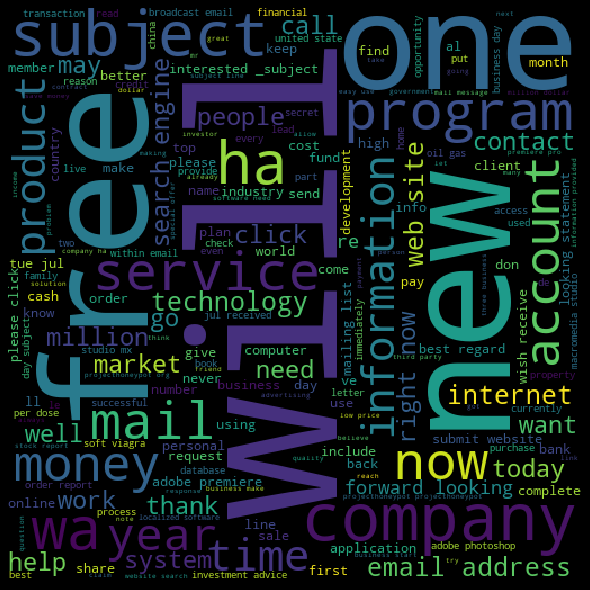

In [13]:
spam_words = ''.join(list(df[df['spam']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Generate Wordcloud of the Ham Emails

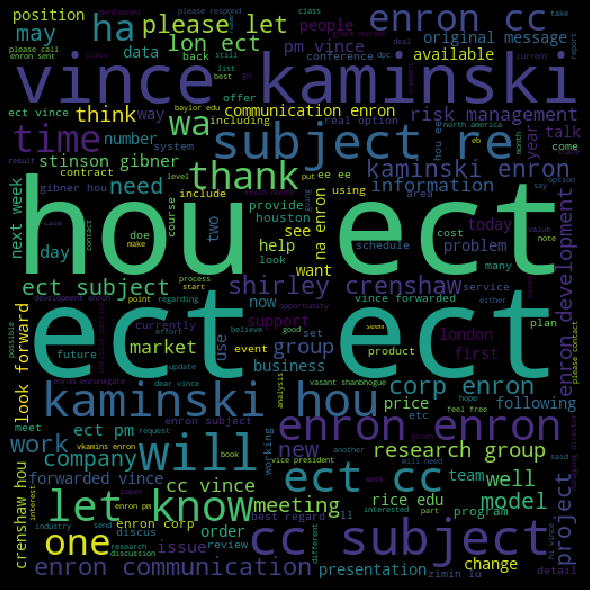

In [14]:
spam_words = ''.join(list(df[df['spam']==0]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Create a Separate Feature Set (Data Matrix X) and Target (1D Array y)

Create a data matrix (X) that contains all features and a 1D target array (y) containing the target.

First, we create separate data frame objects for X and y. Then, we convert the data frame objects into arrays.

In [15]:
X = df["text_lemmatized"] # Data frame containing the target 
y = df['spam'] # Data frame containing the features excluding the target


'''
Convert X & y into Arrays
Use the NumPy asarray() method to convert the Pandas data frame object X and y into numpy arrays.
'''

X = np.asarray(X) # Data Matrix containing all features excluding the target
y = np.asarray(y) # 1D target array

print("Data Matrix (X) Shape: ", X.shape)
print("Label array (y) Shape: ", y.shape)

print("\nData Matrix (X) Type: ", X.dtype)
print("Label array (y) Type: ", y.dtype)

# Read a random "email" from X
print("\nA random email:\n")
print(X[0])

Data Matrix (X) Shape:  (5728,)
Label array (y) Shape:  (5728,)

Data Matrix (X) Type:  object
Label array (y) Type:  int64

A random email:

subject : naturally irresistible your corporate identity lt is really hard to recollect a company : the market is full of suqgestions and the information isoverwhelminq ; but a good catchy logo , stylish statlonery and outstanding website will make the task much easier . we do not promise that havinq ordered a iogo your company will automaticaily become a world ieader : it isguite ciear that without good product , effective business organization and practicable aim it will be hotat nowadays market ; but we do promise that your marketing effort will become much more effective . here is the list of clear benefit : creativeness : hand - made , original logo , specially done to reflect your distinctive company image . convenience : logo and stationery are provided in all format ; easy - to - use content management system letsyou change your website c

## Create Train and Test Dataset

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# <font color=blue> 2. Feature Extraction </font>

## b) Text Preprocessing & c) Feature Vectorization

We perform two tasks.
- Text Preprocessing
- Converting each document (email) into vectors of numbers

## Text Preprocessing

- Tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.
- Removing stop words.

## Converting Each Document (email) into Vectors of Numbers

There are two methods for counting the occurrences of tokens in each document.
- Bag of Words using CountVectorizer()
- TF-IDF using TfidfTransformer()

Note that CountVectorizer() performs the text preprocessing.

### <font color=red> Note: </font>

We can combine text preprocessing, feature vectorization and model training using the sklearn **Pipeline** object. This Pipeline object can be used for model selection and for training the optimal model. 

Below we show how to do text preprocessing and feature vectorization, but we will not use it. It is provided only for illustrative purpose. This code should be used when the feature vectorization is required to be done separately. Two types of vectorization can be done.

- Count vectorization
- TF-IDF vectorization


Skip to "Model Selection".

In [17]:
'''
Depending on the problem scenario, there are various ways of creating the count vectorizer object
'''
#count_vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))
#count_vect = CountVectorizer(lowercase=True, stop_words='english')
#count_vect = CountVectorizer(lowercase=True, stop_words='english', binary=True)
count_vect = CountVectorizer()



# Create a matrix representation of the documents
# Each row represents a single document
# Each column represents the term frequecy for each feature
X_train_vectorized_features = count_vect.fit_transform(X_train).todense()

print("\nSize of Vocabulary: ", len(count_vect.vocabulary_))


print("\nVectorized Training Data Matrix Dimension: ", X_train_vectorized_features.shape)

print("\nType of the Vectorized Training Data Matrix: ")
print(type(X_train_vectorized_features))


# Transform documents to document-term matrix.
# Extract token counts out of raw text documents using the vocabulary fitted with fit 
# or the one provided to the constructor.
X_test_vectorized_features = count_vect.transform(X_test).todense()
print("\nVectorized Test Data Matrix Dimension: ", X_test_vectorized_features.shape)


# TF-IDF Vectorization
tfidf_transformer = TfidfTransformer()
X_train_vectorized_features_tfidf = tfidf_transformer.fit_transform(X_train_vectorized_features).todense()
print(X_train_vectorized_features_tfidf.shape)


X_test_vectorized_features_tfidf = tfidf_transformer.transform(X_test_vectorized_features).todense()
print("\nVectorized Test Data Matrix (TF-IDF) Dimension: ", X_test_vectorized_features_tfidf.shape)


print("\nVectorized Training Data: Row 1, Columns 1 - 20: ", X_train_vectorized_features[0, 0:20])
print("\nVectorized (TF-IDF) Training Data: Row 1, Columns 1 - 20: ", X_train_vectorized_features_tfidf[0, 0:20])


Size of Vocabulary:  31364

Vectorized Training Data Matrix Dimension:  (4582, 31364)

Type of the Vectorized Training Data Matrix: 
<class 'numpy.matrix'>

Vectorized Test Data Matrix Dimension:  (1146, 31364)
(4582, 31364)

Vectorized Test Data Matrix (TF-IDF) Dimension:  (1146, 31364)

Vectorized Training Data: Row 1, Columns 1 - 20:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Vectorized (TF-IDF) Training Data: Row 1, Columns 1 - 20:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Models

We will use the following three models for experimentation.

- Experiment 1: Multinomial NB
- Experiment 2: Multinomial NB (TF-IDF Features)
- Experiment 3: Multivariate Bernoulli NB

# <font color=blue> 3. Model Selection </font>


There are <strong><font color=red>no hyperparameters</font></strong> in a NB model except the Laplace smoothing parameter alpha.

However, there are multiple hyperparameters for the CountVectorizer() and TfidfTransformer(). We need to select the best model based on the optimal values of these hyperparameters. This process is called model selection or hyperparameter tuning.

For hyperparameter tuning, we will build a compund classifier using the sklearn Pipeline class. It will combine the CountVectorizer(), TfidfTransformer() and MultinomialNB()/BernoulliNB objects and will create a single object.

The best way to do hyperparameter tuning is to use cross-validation. We will use Scikit-Learn’s GridSearchCV to search the combinations of hyperparameter values that provide best performance.

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. It will evaluate all the possible combinations of hyperparameter values, using cross-validation. 



## Important:

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use "f1_micro" scoring function. The f1_micro function is the average of the F1 score of each class with weighting depending on the average parameter.

In the binary classification, f1 score function can be used. We may also use the precision, recall, roc_auc functions.

## Experiment 1: Multinomial NB - Building a Pipeline for Hyperparameter Tuning

To denote the module objects in the Pipeline we use arbitrary names: "vect" and "clf".

We use these names to perform grid search for optimal hyperparameters. 

In [18]:
text_clf_multinomialNB = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', MultinomialNB()),
    ])

## Experiment 1: Multinomial NB - Model Selection: Hyperparameter Tuning

In [19]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__alpha': [0.0001, 0.001, 0.1, 1.0, 1.5, 2.0],
}

clf_multinomial_cv = GridSearchCV(text_clf_multinomialNB, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

clf_multinomial_cv = clf_multinomial_cv.fit(X_train, y_train)


params_optimal_clf_multinomial = clf_multinomial_cv.best_params_

print("\nBest Score: %f" % clf_multinomial_cv.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, params_optimal_clf_multinomial[param_name]))
    
print("\n")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   55.6s finished



Best Score: 0.987900

Optimal Hyperparameter Values: 
clf__alpha: 0.1
vect__ngram_range: (1, 2)
vect__stop_words: 'english'


CPU times: user 3.82 s, sys: 1.17 s, total: 4.98 s
Wall time: 58.1 s


# <font color=blue> 4. Experiment 1: Multinomial NB - Train the Optimal Model </font>

Using the optimal hyperparameter values, create the optimal model. Then, fit the model.

In [20]:
multinomialNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=False)),
        ('clf', MultinomialNB(alpha=0.1)),
    ])

multinomialNB_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)

# <font color=blue> 5. Experiment 1: Multinomial NB - Evaluate the Model on Test Data </font>

In [21]:
print("Test Accuracy: ", multinomialNB_clf.score(X_test, y_test))

y_test_predicted = multinomialNB_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Ham", "Spam"]))

Test Accuracy:  0.9921465968586387

Test Confusion Matrix:
[[853   3]
 [  6 284]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       856
        Spam       0.99      0.98      0.98       290

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



# Experiment 2: Multinomial NB (TF-IDF)

We would like to see how the Multinomial model performs if we use the TF-IDF feature vectors.

## Experiment 2: Multinomial NB (TF-IDF) - Building a Pipeline for Hyperparameter Tuning

To denote the module objects in the Pipeline we use arbitrary names: "vect", "tfidf" and "clf".

We use these names to perform grid search for optimal hyperparameters. 

In [22]:
text_clf_multinomialNB_tfidf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

## Experiment 2: Multinomial NB (TF-IDF) - Model Selection: Hyperparameter Tuning

In [23]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__alpha': [0.001, 0.1, 1.0, 1.5],
}

clf_multinomial_tfidf_cv = GridSearchCV(text_clf_multinomialNB_tfidf, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

clf_multinomial_tfidf_cv = clf_multinomial_tfidf_cv.fit(X_train, y_train)



params_optimal_clf_multinomial_tfidf = clf_multinomial_tfidf_cv.best_params_

print("\nBest Score: %f" % clf_multinomial_tfidf_cv.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, params_optimal_clf_multinomial_tfidf[param_name]))
    
print("\n")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   39.6s finished



Best Score: 0.984499

Optimal Hyperparameter Values: 
clf__alpha: 0.001
vect__ngram_range: (1, 2)
vect__stop_words: 'english'


CPU times: user 4.22 s, sys: 1.35 s, total: 5.57 s
Wall time: 42.2 s


## Experiment 2: Multinomial NB (TF-IDF) - Train the Optimal Model 

In [24]:
multinomialNB_clf_tfidf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=0.1)),
    ])

multinomialNB_clf_tfidf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)

## Experiment 2: Multinomial NB (TF-IDF) - Evaluate the Model on Test Data 

In [25]:
print("Test Accuracy: ", multinomialNB_clf_tfidf.score(X_test, y_test))

y_test_predicted = multinomialNB_clf_tfidf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Ham", "Spam"]))

Test Accuracy:  0.9712041884816754

Test Confusion Matrix:
[[856   0]
 [ 33 257]]

Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       856
        Spam       1.00      0.89      0.94       290

    accuracy                           0.97      1146
   macro avg       0.98      0.94      0.96      1146
weighted avg       0.97      0.97      0.97      1146



## <font color=maroon> Observation on Multinomial Model With TF-IDF Feature Vectors </font>

We don't observe any performance improvements with the TF-IDF features. While precision increased slightly, the recall decreased for the "Spam" class.

#  Experiment 3: Multivariate Bernoulli NB

We investigate the performance of the Multivariate Bernoulli Model.

### <font color=red> Note: </font>
The "binary" attribute of the CountVectorizer() object should be set to "True".

## Experiment 3: Multivariate Bernoulli - Building a Pipeline for Hyperparameter Tuning


In [26]:
text_clf_bernoulliNB = Pipeline([
        ('vect', CountVectorizer(binary=True)),
        ('clf', BernoulliNB()),
    ])

## Experiment 3: Multivariate Bernoulli - Model Selection: Hyperparameter Tuning

In [27]:
%%time
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': ['english', None],
    'clf__alpha': [0.001, 0.1, 1.0, 1.5],
}

clf_bernoulli_cv = GridSearchCV(text_clf_bernoulliNB, param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

clf_bernoulli_cv = clf_bernoulli_cv.fit(X_train, y_train)


params_optimal_clf_bernoulli = clf_bernoulli_cv.best_params_

print("\nBest Score: %f" % clf_bernoulli_cv.best_score_)
print("\nOptimal Hyperparameter Values: ")

for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, params_optimal_clf_bernoulli[param_name]))
    
print("\n")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   38.1s finished



Best Score: 0.982180

Optimal Hyperparameter Values: 
clf__alpha: 0.1
vect__ngram_range: (1, 2)
vect__stop_words: 'english'


CPU times: user 3.8 s, sys: 1.41 s, total: 5.21 s
Wall time: 40.6 s


## Experiment 3: Multivariate Bernoulli - Train the Optimal Model

In [28]:
bernoulliNB_clf = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2), binary=True)),
        ('clf', BernoulliNB(alpha=0.1)),
    ])

bernoulliNB_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

## Experiment 3: Multivariate Bernoulli - Evaluate the Model on Test Data 

In [29]:
print("Test Accuracy: ", bernoulliNB_clf.score(X_test, y_test))

y_test_predicted = bernoulliNB_clf.predict(X_test)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted, target_names = ["Ham", "Spam"]))

Test Accuracy:  0.987783595113438

Test Confusion Matrix:
[[844  12]
 [  2 288]]

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99       856
        Spam       0.96      0.99      0.98       290

    accuracy                           0.99      1146
   macro avg       0.98      0.99      0.98      1146
weighted avg       0.99      0.99      0.99      1146



## <font color=maroon> Observation on Multivariate Bernoulli Model </font>

We observe the performance of the Multivariate Bernoulli Model is slightly lower (but comparable) to the Multinomial model.